In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def process_eval_file(file_name:str):
    
    try:
        eva_results = pd.read_excel(f'{file_name}.xlsx')
    except:
        return None
    
    eva_results.loc[:,'SR_processed'] = eva_results.apply(lambda row: row.SR.replace('[',''), axis=1)
    eva_results.loc[:,'SR_processed'] = eva_results.apply(lambda row: row.SR_processed.replace(']',''), axis=1)
    eva_results.loc[:,'SR_processed'] = eva_results.apply(lambda row: row.SR_processed.split(','), axis=1)

    eva_results.loc[:,'action_record_processed'] = eva_results.apply(lambda row: row.action_record.replace('[',''), axis=1)
    eva_results.loc[:,'action_record_processed'] = eva_results.apply(lambda row: row.action_record_processed.replace(']',''), axis=1)
    eva_results.loc[:,'action_record_processed'] = eva_results.apply(lambda row: row.action_record_processed.split(','), axis=1)

    return eva_results

In [5]:
eval_f_list = []

for i in range(11):
    
    name_prefix = 'eval_results/original_experiment_results_para_config_'
    f_num = i+1
    f_name = name_prefix + str(f_num)
    
    if process_eval_file(f_name) is not None:
        eval_f_list.append(process_eval_file(f_name))

In [6]:
eval_full_file = pd.concat(eval_f_list)

In [8]:
tot_experiments = eval_full_file.shape[0]
tot_experiments

360

In [9]:
eval_full_file.to_excel('original_experiment_evals_complete.xlsx',index=False)

In [47]:
eval_full_file.loc[:,'positive_SR_idx'] = eval_full_file.apply(lambda row: [idx for idx,val in enumerate(row.SR_processed) if float(val)>0], axis=1)
eval_full_file.positive_SR_idx = eval_full_file.positive_SR_idx.apply(lambda cell: np.nan if len(cell)==0 else cell)
eval_full_file.dropna(subset=['positive_SR_idx'],inplace=True)

eval_full_file.loc[:, 'action_SR_pairs'] = eval_full_file.apply(lambda row: [(int(row.action_record_processed[val]),round(float(row.SR_processed[val]),4)) for val in row.positive_SR_idx ] , axis=1)

In [48]:
# only select the first action count (if multiple SR-action pairs available)
eval_full_file.action_SR_pairs = eval_full_file.action_SR_pairs.apply(lambda cell: [cell[0]])

In [49]:
action_sr_pair_list_original = []
for experiment in eval_full_file.action_SR_pairs.values:
    for action_sr_pair in experiment:
        action_sr_pair_list_original.append(action_sr_pair)
        
action_sr_pairs_original = np.array(action_sr_pair_list_original)

action_sr_pairs_original_df = pd.DataFrame(action_sr_pairs_original)
action_sr_pairs_original_df.columns = ['actions','sr']
action_sr_pairs_original_df.sort_values('actions',inplace=True)

action_sr_pairs_original_df.loc[:,'pct_sr'] = 1/ tot_experiments

action_sr_pairs_original_df.loc[:,'cum_pct_sr']  = action_sr_pairs_original_df.pct_sr.cumsum()
action_sr_pairs_original_df.head(10)

,actions,sr,pct_sr,cum_pct_sr
32,8291.0,0.05,0.002778,0.002778
30,8307.0,0.50,0.002778,0.005556
31,8432.0,3.30,0.002778,0.008333
5,8857.0,0.20,0.002778,0.011111
3,8937.0,4.50,0.002778,0.013889
4,8966.0,1.60,0.002778,0.016667
7,9122.0,44.20,0.002778,0.019444
8,9210.0,0.40,0.002778,0.022222
9,9249.0,65.10,0.002778,0.025000
6,9275.0,3.50,0.002778,0.027778


In [50]:
action_sr_pairs_original_df.to_csv('original_algo_eval_data_for_plot.csv', index=False)

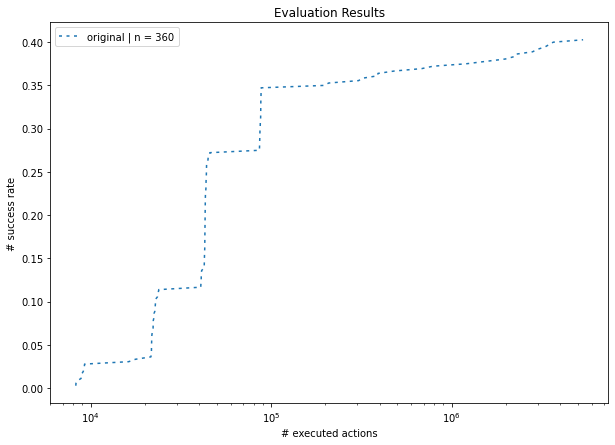

In [51]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(action_sr_pairs_original_df.actions
        , action_sr_pairs_original_df.cum_pct_sr
        , linestyle=':'
        , dashes=(2, 3)
        , label = f'original | n = {tot_experiments}')

plt.ylabel('# success rate')
plt.xlabel('# executed actions')
plt.title('Evaluation Results')
plt.legend(loc = 'upper left')
plt.xscale('log')
plt.show()